In [1]:
import logging
import os
import cloudstorage as gcs

In [54]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/filipclaesson/Downloads/solar_fetch.json'

# Write to storage (used in Cloud Function)

In [113]:
import json
## File exists?
from google.cloud import storage
# create storage client
storage_client = storage.Client(project='custom-hold-263221')
# get bucket with name
bucket = storage_client.get_bucket('solar_storage')
# get bucket data as blob
file_name = '2020/09/03/data_test.txt'
blob = bucket.get_blob(file_name)
if not storage.Blob(bucket=bucket, name=file_name).exists(storage_client):
    print('no file')
    new_file = bucket.blob(file_name)
    new_file.upload_from_string(json.dumps(eval(a)))
else:
    print('done')

no file


NameError: name 'a' is not defined

## Create a temporary table with the storage data

In [17]:
def if_tbl_exists(client, table_ref):
    from google.cloud.exceptions import NotFound
    try:
        client.get_table(table_ref)
        return True
    except NotFound:
        return False


from google.cloud import bigquery
client = bigquery.Client(project='custom-hold-263221')
table = bigquery.Table('custom-hold-263221.solar.solar_export')
external_config = bigquery.ExternalConfig("NEWLINE_DELIMITED_JSON")
external_config.source_uris = ["gs://solar_storage/solar_export/*"]
external_config.autodetect = True
external_config.ignore_unknown_values=False
table.external_data_configuration = external_config

if if_tbl_exists(client, table):
    client.delete_table(table)
    
client.create_table(table,exists_ok=True)

Table(TableReference(DatasetReference('custom-hold-263221', 'solar'), 'solar_export'))

In [63]:
from google.cloud import bigquery

client = bigquery.Client(project='custom-hold-263221')
sql = """
    SELECT published_at,current_converted

    FROM `custom-hold-263221.solar.solar_export` order by 1 desc
"""

# Run a Standard SQL query using the environment's default project
df = client.query(sql).to_dataframe()

# Run a Standard SQL query with the project set explicitly
project_id = 'custom-hold-263221'
df = client.query(sql, project=project_id).to_dataframe()

In [64]:
df = df.set_index('published_at')

In [73]:
df.loc['2020-09-14']['current_converted'].sum()/12

3.9724999999999997

In [66]:
df.index

DatetimeIndex(['2020-09-14 17:17:02.895000+00:00',
               '2020-09-14 17:11:52.103000+00:00',
               '2020-09-14 17:06:41.796000+00:00',
               '2020-09-14 17:01:31.275000+00:00',
               '2020-09-14 16:56:20.809000+00:00',
               '2020-09-14 16:51:10.264000+00:00',
               '2020-09-14 16:45:59.795000+00:00',
               '2020-09-14 16:40:49.438000+00:00',
               '2020-09-14 16:35:38.909000+00:00',
               '2020-09-14 16:30:28.417000+00:00',
               ...
               '2020-09-04 20:12:14.323000+00:00',
               '2020-09-04 20:07:04.333000+00:00',
               '2020-09-04 20:01:54.352000+00:00',
               '2020-09-04 19:56:44.603000+00:00',
               '2020-09-04 19:51:34.333000+00:00',
               '2020-09-04 19:46:24.359000+00:00',
               '2020-09-04 19:41:14.416000+00:00',
               '2020-09-04 19:36:04.351000+00:00',
               '2020-09-04 19:30:54.361000+00:00',
            

In [50]:
df.sort_index(ascending=False).head(10)

,current_converted
published_at,
2020-09-13 11:11:11.351000+00:00,1.00
2020-09-13 11:06:01.983000+00:00,1.06
2020-09-13 11:00:50.441000+00:00,0.69
2020-09-13 10:55:39.970000+00:00,0.06
2020-09-13 10:50:29.493000+00:00,0.57
2020-09-13 10:45:19.043000+00:00,0.86
2020-09-13 10:40:08.583000+00:00,0.75
2020-09-13 10:34:58.130000+00:00,1.16
2020-09-13 10:29:47.657000+00:00,1.52


In [93]:
#df['voltage_converted'].mean()/df['current_raw'].mean()


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


<AxesSubplot:xlabel='published_at'>

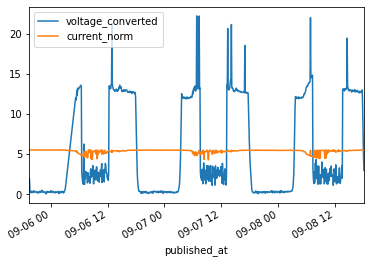

In [89]:
df['current_norm'] = df['current_raw'] * (df['voltage_converted'].mean()/df['current_raw'].mean())
df[['voltage_converted','current_norm']].plot()